# Load the Experiment Results

In [2]:
import glob
import json
import pandas as pd
import os


In [3]:
# rename file to glob can find them
# for file in glob.glob(f"instances/linear/result_neural_network_ensemble_*.txt"):
#   print(file)
#   seperated = file.split("_")

#   if len(seperated) == 6:
#     del seperated[4]
#     seperated[3] = "ensemble90"

#     new_name = "_".join(seperated)
#     os.rename(file, new_name)

instances/linear\result_neural_network_ensemble_10002.txt
instances/linear\result_neural_network_ensemble_1002.txt
instances/linear\result_neural_network_ensemble_10059.txt
instances/linear\result_neural_network_ensemble_10106.txt
instances/linear\result_neural_network_ensemble_10128.txt
instances/linear\result_neural_network_ensemble_10132.txt
instances/linear\result_neural_network_ensemble_10170.txt
instances/linear\result_neural_network_ensemble_10171.txt
instances/linear\result_neural_network_ensemble_10173.txt
instances/linear\result_neural_network_ensemble_10199.txt
instances/linear\result_neural_network_ensemble_10207.txt
instances/linear\result_neural_network_ensemble_1021.txt
instances/linear\result_neural_network_ensemble_10215.txt
instances/linear\result_neural_network_ensemble_1026.txt
instances/linear\result_neural_network_ensemble_10351.txt
instances/linear\result_neural_network_ensemble_10361.txt
instances/linear\result_neural_network_ensemble_10388.txt
instances/linear\

In [4]:
# Somehow the solve nodes crashed midway through without noticing: the following is a quick and dirty fix


all_problems = set()

for file in glob.glob(f"instances/linear/stats_default*"):
  all_problems.add(file.split("_")[-1].split(".")[0])

for strat in ["predbound", "neural_network_ensemble", "neural_network_ensemble90", "monte_carlo_dropout"]:
  seen = set()  
  for file in glob.glob(f"instances/linear/stats_{strat}_*.json"):
    seen.add(file.split("_")[-1].split(".")[0])
  all_problems = all_problems.intersection(seen)

print(len(all_problems))  

3806


In [5]:
strategies = ["default", "predbound", "neural_network_ensemble", "neural_network_ensemble90", "monte_carlo_dropout"]
dataframe_map = {}

def parse_time(time):
  return float(time.split(":")[-1])

for strat in strategies:
  total_time = []
  solve_time = []
  objective = []
  status = []
  
  for problem in all_problems:
    # open corresponding stats and result files
    stats = json.load(open(f"instances/linear/stats_{strat}_{problem}.json"))
    result = open(f"instances/linear/result_{strat}_{problem}.txt")

    solve_status = result.readline().split()[1]

    if solve_status == "UNSATISFIABLE" or solve_status == "UNKNOWN":
      total_time.append(-1)
      solve_time.append(-1)
      objective.append(-1)
      status.append(solve_status)
    else:
      # in case of satifiability or optimality
      total_time.append(parse_time(stats["time"]) if "time" in stats else parse_time(stats["solveTime"]))
      solve_time.append(parse_time(stats["solveTime"]))
      objective.append(stats["objective"])
      status.append(solve_status)

  print(strat, len(status))
  df = pd.DataFrame(data={'total-time': total_time, 
                          'solve-time': solve_time, 
                          'objective':objective, 
                          'status':status})
  dataframe_map[strat] = df

default 3806
predbound 3806
neural_network_ensemble 3806
neural_network_ensemble90 3806
monte_carlo_dropout 3806


In [6]:
# check for true optimality for non-default modes: bounds may create artificially low optimum
df = pd.DataFrame()

count = 0

for index, entry in dataframe_map["default"].iterrows():
  if entry['status'] == 'OPTIMAL_SOLUTION':
    for strat in ["predbound", "neural_network_ensemble", "neural_network_ensemble90", "monte_carlo_dropout"]:
      # if greater objective value was found than default method, solution can never be optimal
      if dataframe_map[strat].iloc[index]['objective'] > entry['objective']:
        dataframe_map[strat].at[index, 'status'] = 'SATISFIED'
        count += 1

print(count)

377


In [7]:
dataframe_map["predbound"].tail()

,total-time,solve-time,objective,status
3801,0.339,0.101419,447,OPTIMAL_SOLUTION
3802,2.631,2.176540,5616,OPTIMAL_SOLUTION
3803,0.380,0.082138,3404,OPTIMAL_SOLUTION
3804,-1.000,-1.000000,-1,UNSATISFIABLE
3805,-1.000,-1.000000,-1,UNKNOWN


# Satisfiability and Optimality of Instances

In [8]:
possible_results = ["OPTIMAL_SOLUTION", "SATISFIED", "UNSATISFIABLE", "UNKNOW"]

for strat in strategies:
  print(strat, dataframe_map[strat]['status'].value_counts())
  print("total", df.shape[0])
  # for result in possible_results:
  #   print(result, dataframe_map[strat])

default OPTIMAL_SOLUTION    3625
SATISFIED            165
UNSATISFIABLE         16
Name: status, dtype: int64
total 0
predbound OPTIMAL_SOLUTION    2568
UNSATISFIABLE        775
SATISFIED            436
UNKNOWN               27
Name: status, dtype: int64
total 0
neural_network_ensemble OPTIMAL_SOLUTION    3632
SATISFIED            155
UNSATISFIABLE         19
Name: status, dtype: int64
total 0
neural_network_ensemble90 OPTIMAL_SOLUTION    3625
SATISFIED            161
UNSATISFIABLE         20
Name: status, dtype: int64
total 0
monte_carlo_dropout OPTIMAL_SOLUTION    3632
SATISFIED            155
UNSATISFIABLE         19
Name: status, dtype: int64
total 0


# Speedup

[2.22461e-01 4.39626e+00 5.27630e-02 ... 2.52688e-01 3.34802e-01
 5.48231e+01]
[ 0.10395   1.58217   0.02765  ...  0.196588  0.212345 15.386   ]
[ 0.101059  1.22073   0.060786 ...  0.082138 -1.       -1.      ]
[1662 6502  145 ... 3404 3487 3429]
[1662 6502  145 ... 3404 3487 3456]
[1662 6502  148 ... 3404   -1   -1]
[ True  True False ...  True False False]
----
[0.222461 4.39626  0.166161 ... 0.36349  6.33533  0.252688]
[0.10395  1.58217  0.117831 ... 0.204752 4.92214  0.196588]
[0.101059 1.22073  0.091992 ... 0.101419 2.17654  0.082138]


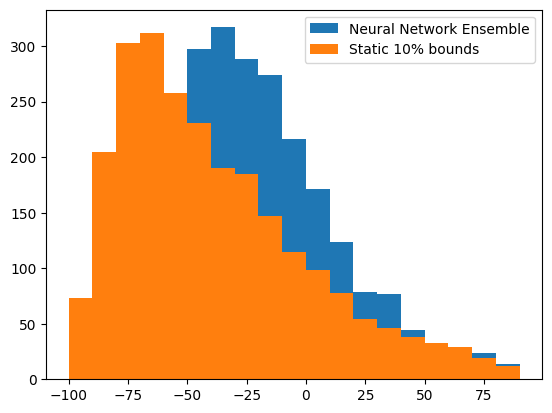

In [12]:
import numpy as np
import matplotlib.pyplot as plt

default_times = dataframe_map['default']['solve-time'].to_numpy()

def calculate_speedup(new_times, baseline):
  return ((new_times - baseline) / baseline) * 100

predbound_times = dataframe_map['predbound']['solve-time'].to_numpy()
ensemble_times = dataframe_map['neural_network_ensemble']['solve-time'].to_numpy()

# only consider cases where both strategies were able to solve problem
predbound_optimal = dataframe_map['predbound']['status'].to_numpy() == "OPTIMAL_SOLUTION"
ensemble_optimal = dataframe_map['neural_network_ensemble']['status'].to_numpy() == "OPTIMAL_SOLUTION"
both_solved = predbound_optimal & ensemble_optimal
predbound_speedup_percentage = calculate_speedup(predbound_times[both_solved], default_times[both_solved])
ensemble_speedup_percentage = calculate_speedup(ensemble_times[both_solved], default_times[both_solved])


print(default_times)
print(ensemble_times)
print(predbound_times)
print(dataframe_map['default']['objective'].to_numpy())
print(dataframe_map['neural_network_ensemble']['objective'].to_numpy())
print(dataframe_map['predbound']['objective'].to_numpy())
print(both_solved)
print("----")
print(default_times[both_solved])
print(ensemble_times[both_solved])
print(predbound_times[both_solved])

plt.hist(ensemble_speedup_percentage, list(range(-100, 100, 10)), label="Neural Network Ensemble")
plt.hist(predbound_speedup_percentage, list(range(-100, 100, 10)), label="Static 10% bounds")
plt.legend()


[2.22461e-01 4.39626e+00 5.27630e-02 ... 2.52688e-01 3.34802e-01
 5.48231e+01]
[9.53420e-02 4.17316e+00 1.54660e-02 ... 4.28843e-01 1.76117e-01
 2.12550e+01]
[ 0.101059  1.22073   0.060786 ...  0.082138 -1.       -1.      ]
[1662 6502  145 ... 3404 3487 3429]
[1662 6502  145 ... 3404 3487 3456]
[1662 6502  148 ... 3404   -1   -1]
[ True  True False ...  True False False]
----
[0.222461 4.39626  0.166161 ... 0.36349  6.33533  0.252688]
[0.095342 4.17316  0.11625  ... 0.190924 6.95588  0.428843]
[0.101059 1.22073  0.091992 ... 0.101419 2.17654  0.082138]


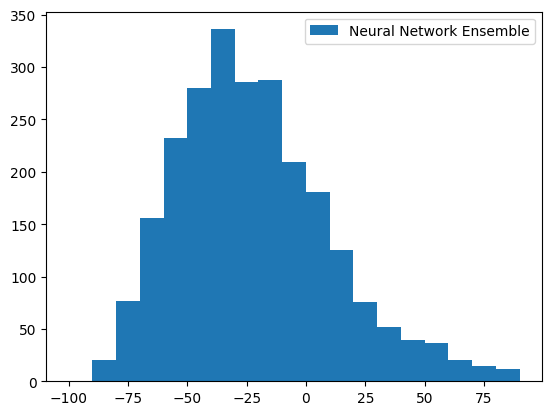

In [10]:
import numpy as np
import matplotlib.pyplot as plt

default_times = dataframe_map['default']['solve-time'].to_numpy()

def calculate_speedup(new_times, baseline):
  return ((new_times - baseline) / baseline) * 100

predbound_times = dataframe_map['predbound']['solve-time'].to_numpy()
ensemble_times = dataframe_map['neural_network_ensemble90']['solve-time'].to_numpy()

# only consider cases where both strategies were able to solve problem
predbound_optimal = dataframe_map['predbound']['status'].to_numpy() == "OPTIMAL_SOLUTION"
ensemble_optimal = dataframe_map['neural_network_ensemble90']['status'].to_numpy() == "OPTIMAL_SOLUTION"
both_solved = predbound_optimal & ensemble_optimal
predbound_speedup_percentage = calculate_speedup(predbound_times[both_solved], default_times[both_solved])
ensemble_speedup_percentage = calculate_speedup(ensemble_times[both_solved], default_times[both_solved])


print(default_times)
print(ensemble_times)
print(predbound_times)
print(dataframe_map['default']['objective'].to_numpy())
print(dataframe_map['neural_network_ensemble']['objective'].to_numpy())
print(dataframe_map['predbound']['objective'].to_numpy())
print(both_solved)
print("----")
print(default_times[both_solved])
print(ensemble_times[both_solved])
print(predbound_times[both_solved])

plt.hist(ensemble_speedup_percentage, list(range(-100, 100, 10)), label="Neural Network Ensemble")
# plt.hist(predbound_speedup_percentage, list(range(-100, 100, 10)), label="Static 10% bounds")
plt.legend()
